In [1]:
import os

from keras_preprocessing.image import ImageDataGenerator

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
from ml.eval import eval_model
from ml.pipeline import FeitDataPipeline
from tensorflow import keras

from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import concatenate

from cfg import *

from livelossplot import PlotLossesKerasTF

print(os.getcwd())
os.chdir('/home/jelinek/recetox/')

name = "MyCNNInception"


/home/jelinek/recetox/histoseg/notebooks/MyCNNInception


In [2]:
class MySimpleCNNInceptionModule(FeitDataPipeline):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)


        self.params.name = name
        self.params.tile_size=256
        self.params.number_of_classes = 11

    @staticmethod
    def get_inception_module_dim_reduction(prev_layer, filters_1, filters_2):
        c11 = keras.layers.Conv2D(filters=filters_1, kernel_size=(1,1), padding='same')(prev_layer)
        c12 = keras.layers.Conv2D(filters=filters_2, kernel_size=(1,1), padding='same')(prev_layer)
        c13 = keras.layers.Conv2D(filters=filters_1, kernel_size=(1,1), padding='same')(prev_layer)
        p1 = keras.layers.MaxPooling2D(padding='same', strides=(1,1), pool_size=(3,3))(prev_layer)

        c21 = keras.layers.Conv2D(filters=filters_2, kernel_size=(3,3), padding='same')(c12)
        c22 = keras.layers.Conv2D(filters=filters_2, kernel_size=(5,5), padding='same')(c13)
        c23 = keras.layers.Conv2D(filters=filters_2, kernel_size=(1,1), padding='same')(p1)

        output_layer = concatenate([c11, c21, c22, c23], axis=-1)

        return output_layer


    @staticmethod
    def get_compiled_model():
        inputs = keras.Input(shape=(256, 256, 3))

        x = MySimpleCNNInceptionModule.get_inception_module_dim_reduction(inputs,
                                                filters_1=4,
                                                filters_2=4)

        x = keras.layers.MaxPooling2D(padding='same', pool_size=(2, 2))(x)
        x = keras.layers.BatchNormalization(axis=3, epsilon=1.001e-5)(x)

        x = MySimpleCNNInceptionModule.get_inception_module_dim_reduction(x,
                                                filters_1=8,
                                                filters_2=8)
        x = keras.layers.MaxPooling2D(padding='same', pool_size=(2, 2))(x)
        x = keras.layers.BatchNormalization(axis=3, epsilon=1.001e-5)(x)


        x = MySimpleCNNInceptionModule.get_inception_module_dim_reduction(x,
                                                filters_1=16,
                                                filters_2=16)
        x = keras.layers.MaxPooling2D(padding='same', pool_size=(2, 2))(x)
        x = keras.layers.BatchNormalization(axis=3, epsilon=1.001e-5)(x)

        x = MySimpleCNNInceptionModule.get_inception_module_dim_reduction(x,
                                                filters_1=32,
                                                filters_2=32)
        x = keras.layers.MaxPooling2D(padding='same', pool_size=(2, 2))(x)
        x = keras.layers.BatchNormalization(axis=3, epsilon=1.001e-5)(x)

        x = MySimpleCNNInceptionModule.get_inception_module_dim_reduction(x,
                                                filters_1=64,
                                                filters_2=64)
        x = keras.layers.MaxPooling2D(padding='same', pool_size=(2, 2))(x)
        x = keras.layers.BatchNormalization(axis=3, epsilon=1.001e-5)(x)


        x = MySimpleCNNInceptionModule.get_inception_module_dim_reduction(x,
                                                filters_1=128,
                                                filters_2=128)
        x = keras.layers.MaxPooling2D(padding='same', pool_size=(2, 2))(x)
        x = keras.layers.BatchNormalization(axis=3, epsilon=1.001e-5)(x)

        x = keras.layers.Flatten()(x)
        outputs = keras.layers.Dense(units=11, activation='softmax')(x)

        model = keras.Model(inputs, outputs, name='MySimpleCnnFewerLayers')
        model.summary()
        return model

    def get_data_loader_training(self):
        datagen_train = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, samplewise_center=True,
                                           samplewise_std_normalization=True)

        return datagen_train.flow_from_directory(directory=self.params.data_training, color_mode='rgb',
                                                 class_mode='categorical', batch_size=self.params.batch_size,
                                                 shuffle=True,
                                                 target_size=(self.params.tile_size, self.params.tile_size))

    def get_data_loader_validation(self):
        datagen_valid = ImageDataGenerator(samplewise_center=True, samplewise_std_normalization=True)
        return datagen_valid.flow_from_directory(directory=self.params.data_validation, color_mode='rgb',
                                                 class_mode='categorical', batch_size=self.params.batch_size,
                                                 shuffle=False,
                                                 target_size=(self.params.tile_size, self.params.tile_size))


    def _train_model(self, data_train, data_valid):

        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                                      patience=30, min_lr=1e-4, verbose=1,
                                      cooldown=20)

        self.model.fit(data_train,
                       steps_per_epoch=250,
                       epochs=200,
                       shuffle=True,
                       validation_data=data_valid,
                       validation_freq=10,
                       verbose=1,
                       callbacks=[self.tensorboard, reduce_lr, PlotLossesKerasTF()])

In [10]:
pipeline = MySimpleCNNInceptionModule(train_data_dir='data/Feit_colon-annotation-tiles-256/data_train/',
                        valid_data_dir='data/Feit_colon-annotation-tiles-256/data_valid/')

Model: "MySimpleCnnFewerLayers"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 4)  16          ['input_1[0][0]']                
                                                                                                  
 conv2d_2 (Conv2D)              (None, 256, 256, 4)  16          ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 256, 256, 3)  0           ['input_1[0]

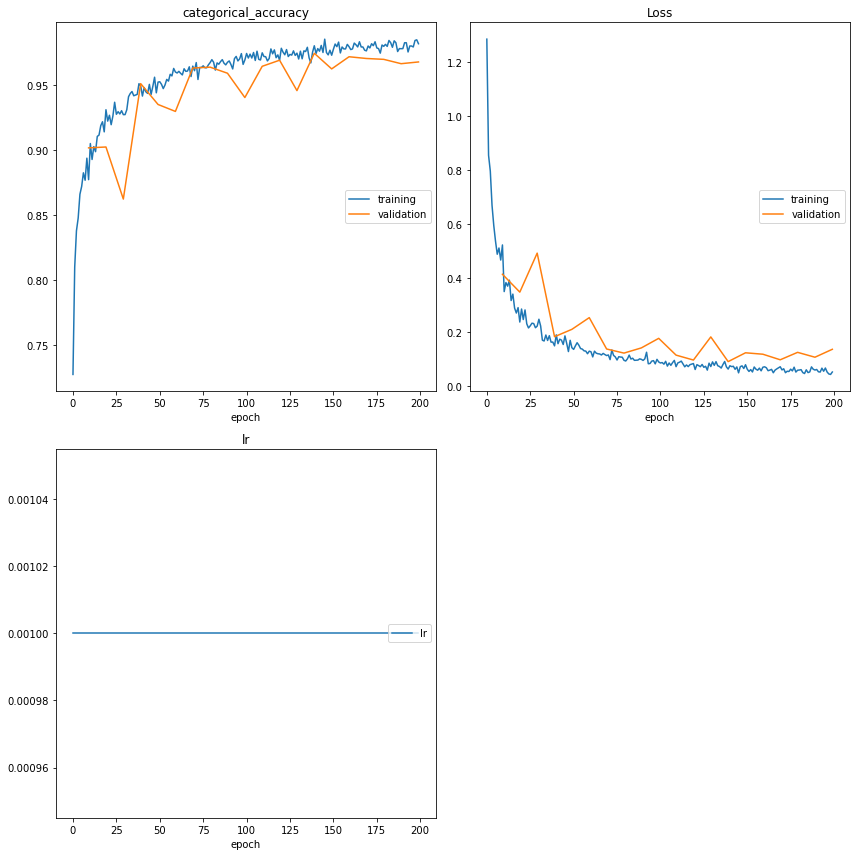

categorical_accuracy
	training         	 (min:    0.728, max:    0.985, cur:    0.982)
	validation       	 (min:    0.863, max:    0.975, cur:    0.968)
Loss
	training         	 (min:    0.044, max:    1.286, cur:    0.053)
	validation       	 (min:    0.091, max:    0.493, cur:    0.137)
lr
	lr               	 (min:    0.001, max:    0.001, cur:    0.001)
250/250 [==============================] - 21s 82ms/step - loss: 0.0528 - categorical_accuracy: 0.9820 - val_loss: 0.1370 - val_categorical_accuracy: 0.9680 - lr: 0.0010
Measuring time
--Iteration 10/10
Batch size: 16
Mean time per tile 0.7276ms
Confusion Matrix
[[330   0   0   0   1   0   1   0   0   0   3]
 [  1  51   4   1   0   0   3   4   0   0   0]
 [  1   3 140   0   0   0   0   1   0   0   0]
 [  0   0   0  11   0   0   0   0   0   0   0]
 [  1   0   4  14 525   0   0   0   0   0   0]
 [  0   0   0   0   0   1   0   0   0   0   0]
 [  0   2   1   0   0   0  74   0   0   0   0]
 [  0   0   0   0   0   0   1  85   0   0   0]
 [

In [11]:
pipeline.execute_pipeline(perform_validation=True, perform_test_segmentation=False)

In [12]:
pipeline.save_pipeline()

In [13]:
eval_model(pipeline.model,
           pipeline.get_data_loader_validation(),
           pipeline_name=name,
           print_confusion_matrix=True,
           save_misclassified=True)

Found 1499 images belonging to 11 classes.
Measuring time
--Iteration 10/10
Batch size: 16
Mean time per tile 0.7200ms
Confusion Matrix
[[330   0   0   0   1   0   1   0   0   0   3]
 [  1  51   4   1   0   0   3   4   0   0   0]
 [  1   3 140   0   0   0   0   1   0   0   0]
 [  0   0   0  11   0   0   0   0   0   0   0]
 [  1   0   4  14 525   0   0   0   0   0   0]
 [  0   0   0   0   0   1   0   0   0   0   0]
 [  0   2   1   0   0   0  74   0   0   0   0]
 [  0   0   0   0   0   0   1  85   0   0   0]
 [  0   0   0   0   0   0   0   0   1   0   0]
 [  0   0   1   0   0   0   0   0   0   0   0]
 [  1   0   0   0   0   0   0   0   0   0 233]]
Classification Report
                             precision    recall  f1-score   support

             adenocarcinoma       0.99      0.99      0.99       335
          blood_and_vessels       0.91      0.80      0.85        64
          connective_tissue       0.93      0.97      0.95       145
                      empty       0.42      1.0

In [3]:
pipeline = FeitDataPipeline.load_pipeline(pipeline_name=name)

In [15]:
from ml.eval import evaluate_segmentation_on_feit_annotation

evaluation_path = Path('data/Feit_colon-annotation_valid/')

segmentation_dir = Path('segmentations') / pipeline.params.name
pipeline.params.number_of_classes = 11
evaluate_segmentation_on_feit_annotation(evaluation_path, pipeline.build_segmenter(),
                                         32, pipeline.params.class_names,
                                         save_segmentations=True, segmentations_dir=segmentation_dir,
                                         neighbourhood_size=1, include_unknown=False)

Processing region 120 out of 120
Post-processing image...
Processing grid point 663499 out of 663499
Processing image took 2160.3922736644745 seconds
Saving file...
File saved to segmentations/MyCNNInception/ns-adenoca-colon-15071-2019-20x-he-4.tiff
----------------------------------------------------
Processing region 255 out of 255
Post-processing image...
Processing grid point 1599360 out of 1599360
Processing image took 5394.003789663315 seconds
Saving file...
File saved to segmentations/MyCNNInception/ns-adenoca-colon-15072-2019-20x-he-a2.tiff
----------------------------------------------------
Processing region 255 out of 255
Post-processing image...
Processing grid point 1544036 out of 1544036
Processing image took 5118.998808860779 seconds
Saving file...
File saved to segmentations/MyCNNInception/ns-adenoca-colon-3043-2019-20x-he-a1.tiff
----------------------------------------------------
Processing region 567 out of 567
Post-processing image...
Processing grid point 3520448 

In [4]:
from ml.eval import evaluate_segmentation_on_feit_annotation

evaluation_path = Path('data/Feit_colon-annotation_valid/')

segmentation_dir = Path('segmentations') / pipeline.params.name

evaluate_segmentation_on_feit_annotation(evaluation_path, pipeline.build_segmenter(),
                                         128, pipeline.params.class_names,
                                         save_segmentations=False, segmentations_dir=segmentation_dir,
                                         neighbourhood_size=1, include_unknown=False)

Processing region 120 out of 120
Post-processing image...
Processing grid point 41664 out of 41664
Processing image took 172.79166984558105 seconds
Processing region 255 out of 255
Post-processing image...
Processing grid point 99960 out of 99960
Processing image took 378.325651884079 seconds
Processing region 255 out of 255
Post-processing image...
Processing grid point 96577 out of 96577
Processing image took 362.9415376186371 seconds
Processing region 567 out of 567
Post-processing image...
Processing grid point 220296 out of 220296
Processing image took 786.2096490859985 seconds
Aggregated evaluation: 
[[25812   371   357   159     8     0    15    86     0     0  6234]
 [  144  3101   302   125   518     0   145   126     0     0   345]
 [  184   523  1122   112    33     0   108   695     0     0   491]
 [    2     9     0   104     0     0     0     0     0     0   685]
 [   91   811   303  2597 11799     0   129    31     0     0   170]
 [   27     0    11   184     0    10    